# Sparse Sheaf Signal Processing

### TO-DO

**Input**: point cloud in R^3
1. Build a graph from the points defining edges where $dist<\sqrt{\epsilon}$ (OK)
2. Approximate an orthonormal basis for every tangent vector bundle with PCA (OK)
3. Alignment: for every point i and each of its neighbors j ($dist<\sqrt{\epsilon}$), build the closest orthogonal transformation matrices (OK)
4. Vector diffusion mapping (OK ~)
5. Define a VDM class that combines everything


**Questions**:
- Should I add code for a scenario where eps < eps_pca even though eps should be larger? Because the neighbors added in the graph creation part are those at distance < sqrt(eps), and in the local pca step I only iterate over those neighbors because I look for points at a distance < sqrt(eps_pca). Otherwise, I'd be looking for points beyond the neighbors

## Graph Creation from Point Cloud via Radius Nearest Neighbors

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

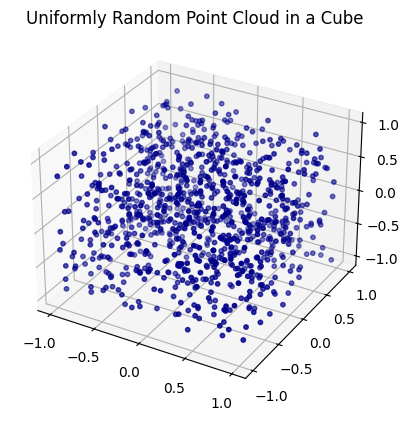

In [2]:
# Generate a cube in R^3 with uniformly random points
N = 1000 # number of points in the cloud
np.random.seed(6111983)
x = np.random.uniform(-1,1,N*3).reshape((N, 3)) # points
# Plot the cube
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker='o', s=10, c='darkblue')
plt.title('Uniformly Random Point Cloud in a Cube')
plt.show()

# Practice

In [3]:
# Build a graph from the point cloud
eps = 0.15 # epsilon for the graph
G = nx.Graph()
G.add_nodes_from(range(N))
rnn = NearestNeighbors(metric='euclidean', radius=np.sqrt(eps), algorithm='auto')
distances, indices = rnn.fit(x).radius_neighbors(x)

# Gauss Kernel
def Gauss(u):
    return np.exp(-u**2) * (u>=0) * (u<=1)

# Add edges where the distance is less than sqrt(eps)
for node_i in range(N):
    for idx_j, node_j in enumerate(indices[node_i]):
        if node_i!=node_j:
            distance = distances[node_i][idx_j]
            weight = Gauss(distance/np.sqrt(eps))
            G.add_edge(node_i, node_j, distance=distance, weight=weight)

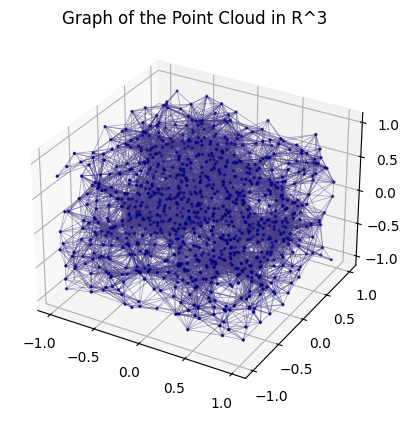

In [4]:
# Plot the cube
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker='o', s=2, c='navy')
# Plot the edges
for edge in G.edges():
    x1, y1, z1 = x[edge[0]]
    x2, y2, z2 = x[edge[1]]
    ax.plot([x1, x2], [y1, y2], [z1, z2], c='darkslateblue', linewidth=0.5, alpha=0.5)
plt.title('Graph of the Point Cloud in R^3')
plt.show()

## Orthonormal Basis Approximation

In [5]:
# Local PCA to approximate the orthonormal bases
# Find the neighbors of every point within a radius eps_pca
eps_pca = 0.1 # epsilon for the local PCA
pca_neighbors = []
for i in range(N):
    pca_neighbors_of_i = []
    for j in G.neighbors(i):
        #print(np.linalg.norm(x[i]-x[j]))
        if np.linalg.norm(x[i]-x[j]) < np.sqrt(eps_pca):
            pca_neighbors_of_i.append(x[j])
    pca_neighbors.append(np.array(pca_neighbors_of_i))

In [6]:
# Shifted pca neighbors (X_i matrices in the paper)
shifted_pca_neighbors = [(pca_neighbors[i]-x[i]).transpose(1,0) for i in range(N)] # 3 x Ni matrices

# Epanechnikov kernel
def K(u):
    return (1-u**2)*(u>=0)*(u<=1)


In [7]:
min([len(pca_neighbors[i]) for i in range(N)])

2

In [8]:
shifted_pca_neighbors[0].shape

(3, 14)

In [9]:
# Scaling matrices (D_i in the paper)
scaling_matrices = [ # Ni x Ni matrices, Ni = number of neighbors of point i
    np.diag(
        [np.sqrt(K(np.linalg.norm(shifted_pca_neighbors[i][:,j])/ (np.sqrt(eps_pca))))
         for j in range(shifted_pca_neighbors[i].shape[1])]
    )
    for i in range(N)
]

In [10]:
scaling_matrices[0].shape

(14, 14)

In [11]:
# Scale the shifted pca neighbor matrices (B_i matrices in the paper)
scaled_shifted_pca_neighbors = [shifted_pca_neighbors[i] @ scaling_matrices[i] for i in range(N)]   # 3 x Ni matrices 

In [12]:
scaled_shifted_pca_neighbors[0].shape

(3, 14)

In [13]:
# Singular value decomposition of the scaled shifted pca neighbor matrices
neighbor_matrices_svd =[np.linalg.svd(scaled_shifted_pca_neighbors[i]) for i in range(N)]

In [14]:
neighbor_matrices_svd[0][0].shape, neighbor_matrices_svd[0][1].shape, neighbor_matrices_svd[0][2].shape

((3, 3), (3,), (14, 14))

In [15]:
# Threshold the information variability in the data
gamma = 0.9
local_dimensions = []

for i in range(N):
    for d in range(3):
        first_d_singular_values_variability = np.sum(neighbor_matrices_svd[i][1][:d])/np.sum(neighbor_matrices_svd[i][1])
        if first_d_singular_values_variability > gamma:
            break
        local_dimensions.append(d+1)

In [16]:
# Estimate of the manifold dimension (d in the paper)
dim_estimate = int(np.median(local_dimensions))
dim_estimate

2

In [17]:
# Get the orthonormal bases of the tangent vector spaces
orthonormal_bases = [neighbor_matrices_svd[i][0][:,:dim_estimate] for i in range(N)]

In [18]:
orthonormal_bases[0].T @ orthonormal_bases[0]

array([[1.0000000e+00, 1.6010772e-16],
       [1.6010772e-16, 1.0000000e+00]])

## Alignment

In [19]:
# Dictionary with ortogonal transformation matrices
alignment_matrices = {}
for i in range(N):
    alignment_matrices[i] = {}
    for j in G.neighbors(i):
        Oij = orthonormal_bases[i].T @ orthonormal_bases[j]
        U, _, V = np.linalg.svd(Oij)
        alignment_matrices[i][j] = U @ V.T

In [20]:
alignment_matrices[0][432]

array([[ 0.53845976, -0.84265123],
       [-0.84265123, -0.53845976]])

In [21]:
alignment_matrices[432][0]

array([[ 0.53845976,  0.84265123],
       [ 0.84265123, -0.53845976]])

## Vector Diffusion Mapping

In [22]:
# Compute the block matrices formed by the weighted alignment matrices and zero blocks (S): dN x dN
d = dim_estimate
block_matrix_S = np.zeros((d*N, d*N))
for i in range(N):
    for j in G.neighbors(i):
        block_matrix_S[d*i:d*(i+1), d*j:d*(j+1)] = G.get_edge_data(i,j)['weight'] * alignment_matrices[i][j]

In [23]:
# Compute diagonal degree block matrix (D and cursive D): dN x dN and N x N
degrees = np.array([sum(G.get_edge_data(i, k)['weight'] for k in G.neighbors(i)) for i in range(N)])
degree_matrix_dN_x_dN = np.kron(np.diag(degrees), np.eye(d))
degree_matrix_N_x_N = np.diag(degrees)

In [24]:
# Weight matrix (W): N x N
weight_matrix_W = np.zeros((N, N))
for edge in G.edges():
    weight_matrix_W[edge[0],edge[1]] = G.get_edge_data(edge[0],edge[1])['weight']
    weight_matrix_W[edge[1],edge[0]] = G.get_edge_data(edge[0],edge[1])['weight']

In [25]:
# Markov transition matric
markov_transition_matrix_A = np.linalg.inv(degree_matrix_N_x_N) @ weight_matrix_W

In [26]:
# Diffusion mapping
def diffusion_mapping(A,t,i):
    '''
    This function returns the diffusion mapping Phi_t(i)=(mu_1^t phi_1(i), mu_2^t phi_2(i), ..., mu_N^t phi_N(i))
    A: Markov transition matrix
    t: time
    i: initial node
    '''
    # Eigendecomposition of A
    eigenvalues, eigenvectors = np.linalg.eig(A)
    return np.array([eigenvectors[i,j]*eigenvalues[j]**t for j in range(len(eigenvalues))])

def diffusion_distance(A,i,j,t,degrees):
    '''
    Function that computes the diffusion distance between nodes i and j
    A = Markov transition matrix
    i = initial node
    j = final node
    degrees = vector of degrees
    '''
    # Matrix A after t steps
    At = np.linalg.matrix_power(A, t)
    squared_distance = np.sum([(At[i,k]-At[j,k])**2/degrees[k] for k in range(N)])
    return np.sqrt(squared_distance)
    
def path_transformation(O,path):
    ''' 
    Function that composes the transformation matrices along a path of length t
    O = alignment matrices
    path = path of length t made of t+1 nodes j_0, j_1, ..., j_(t)
    '''
    ## TO DO: add a logic for when the path is not legal
    #############
    # Compose the alignment matrices along the path
    vdm_transformation = O[path[1]][path[0]]
    for i in range(2,len(path)):
        vdm_transformation = O[path[i]][path[i-1]] @ vdm_transformation
    return vdm_transformation



In [27]:
list(G.neighbors(0))[:5],  list(G.neighbors(36))[:5], list(G.neighbors(28))[:5],   list(G.neighbors(653))[:10],    list(G.neighbors(409))[:10]

([np.int64(432), np.int64(36), np.int64(653), np.int64(465), np.int64(436)],
 [0, 28, np.int64(432), np.int64(653), np.int64(436)],
 [0, np.int64(432), np.int64(36), np.int64(653), np.int64(436)],
 [0, 28, 36, 165, 235, 328, 386, 409, 432, 454],
 [0, 28, 36, 165, 218, 235, 250, 328, 386, np.int64(432)])

In [28]:
dm = diffusion_mapping(markov_transition_matrix_A, 1, 0)

In [29]:
dd = diffusion_distance(markov_transition_matrix_A,0,3,5,np.diag(degree_matrix_N_x_N))
dd

np.float64(0.04127509003140655)

In [30]:
path = [0,36,28,653,409]

tm = path_transformation(alignment_matrices,path)

In [31]:
tm

array([[-0.98835533,  0.15216352],
       [-0.15216352, -0.98835533]])

In [32]:
# Compute the matrix that measures the affinity between nodes i and j
# This is the matrix S^{tilde} in the paper
degree_matrix_diagonal = np.diag(degree_matrix_dN_x_dN)
inv_sqrt_diagonal = 1. / np.sqrt(degree_matrix_diagonal)
inv_sqrt_degree_matrix = np.diag(inv_sqrt_diagonal)
affinity_matrix_S_tilde = inv_sqrt_degree_matrix @ block_matrix_S @ inv_sqrt_degree_matrix

In [33]:
def affinity(S_tilde,i,j,t):
    '''
    Compute the squared Hilbert-Schmidt/ Frobenius norm of the matrix S_tilde^{2t}(i,j)
    S_tilde = affinity matrix
    i = initial node
    j = final node
    t = path length
    '''
    squared_S_tilde = S_tilde**(2*t)
    squared_S_tilde_i_j = squared_S_tilde[i*d:(i+1)*d, j*d:(j+1)*d]
    return np.linalg.norm(squared_S_tilde_i_j)**2

In [34]:
list(G.neighbors(0))[:5]

[np.int64(432), np.int64(36), np.int64(653), np.int64(465), np.int64(436)]

In [35]:
affinity(affinity_matrix_S_tilde,0,28,2)

np.float64(8.389729446693354e-12)

In [36]:
def vdm_distance(S_tilde,i,j,t):
    '''
    Compute the vector diffusion distance between nodes i and j
    S_tilde = affinity matrix
    i = initial node
    j = final node
    t = path length
    '''
    squared_S_tilde = S_tilde**(2*t)
    squared_S_tilde_i_i = squared_S_tilde[i*d:(i+1)*d, i*d:(i+1)*d]
    squared_S_tilde_j_j = squared_S_tilde[j*d:(j+1)*d, j*d:(j+1)*d]
    squared_S_tilde_i_j = squared_S_tilde[i*d:(i+1)*d, j*d:(j+1)*d]
    return np.linalg.norm(squared_S_tilde_i_i)**2 + np.linalg.norm(squared_S_tilde_j_j)**2 - 2*np.linalg.norm(squared_S_tilde_i_j)**2

In [37]:
vdm_distance(affinity_matrix_S_tilde,0,432,1)

np.float64(-2.2227687779859808e-05)

# VDM Class

In [55]:
class VDM:
    def __init__(self, data, eps, eps_pca, gamma=0.9):
        # Hyperparameters
        self.eps = eps
        self.eps_pca = eps_pca
        self.gamma = gamma
        # Data and graph
        self.data = data
        self.N = data.shape[0]
        self.graph = None
        # Orthonormal bases
        self.neighbor_matrices_svd = None    # U_i, Sigma_i, V_i
        self.orthonormal_bases = None   # O_i
        # Alignment
        self.alignment_matrices = None   # O_ij
        self.dim = None   # d
        # Vector Diffusion
        self.weight_matrix = None  # W
        self.transition_matrix = None   # A
        self.eig_transition_matrix = None #  mu_k, phi_k for k=0,1,...,N
        self.alignment_block_matrix = None   # S
        self.affinity_matrix = None    # S_tilde
        self.eig_affinity_matrix = None   # lambda_l, v_l for l=0,1,...,dim*N

    ################################################################
    # Helper functions
    ################################################################

    # Gaussian kernel
    def Gauss(self,u):
        '''
        Function that computes the Gaussian kernel
        '''
        return np.exp(-u**2) * (u>=0) * (u<=1)
    
    # Epanechnikov kernel
    def K(self,u):
        '''
        Function that computes the Epanechnikov kernel
        '''
        return (1-u**2)*(u>=0)*(u<=1)
    
    ################################################################
    # Build the graph from the point cloud
    ################################################################
    
    # Build a graph from the point cloud
    def make_graph(self):
        '''
        Function that builds a networkx graph from the input data
        '''
        N = self.N
        G = nx.Graph() # Create the graph
        G.add_nodes_from(range(N))
        # Find the nearest neighbors of each point within radius sqrt(eps)
        rnn = NearestNeighbors(metric='euclidean', radius=np.sqrt(self.eps), algorithm='auto')
        distances, indices = rnn.fit(self.data).radius_neighbors(self.data)
        # Add edges where the distance is less than sqrt(eps)
        for node_i in range(N):
            for idx_j, node_j in enumerate(indices[node_i]):
                if node_i!=node_j:
                    distance = distances[node_i][idx_j]
                    weight = self.Gauss(distance/np.sqrt(self.eps))
                    G.add_edge(node_i, node_j, distance=distance, weight=weight)
        return G
    
    # Ensure that the graph is built
    def _ensure_graph(self):
        if self.graph is None:
            self.graph = self.make_graph()
    
    ################################################################
    # Orthonormal Basis Approximation
    ################################################################

    # Find the local pca neighbors
    def find_pca_neighbors(self):
        '''
        Function that finds the local pca neighbors
        Returns a list of arrays pca_neighbors where pca_neighbors[i] is the array of
        local pca neighbors of point i
        '''
        self._ensure_graph()
        graph = self.graph
        data = self.data
        N = self.N
        # Find the local pca neighbors
        pca_neighbors = []
        for i in range(N):
            pca_neighbors_of_i = []
            for j in graph.neighbors(i):
                if graph.get_edge_data(i,j)['distance'] < np.sqrt(self.eps_pca):
                    pca_neighbors_of_i.append(data[j])
            pca_neighbors.append(np.array(pca_neighbors_of_i))
        return pca_neighbors

    # Compute the singular value decomposition of the matrices B_i in the paper
    def neighbor_mat_svd(self):
        '''
        Function that computes the singular value decomposition of the scaled shifted pca neighbor matrices
        Returns a list of tuples (U_i, Sigma_i, V_i)
        '''
        self._ensure_graph()
        graph = self.graph
        data = self.data
        N = self.N
        # Find local pca neighbors
        pca_neighbors = self.find_pca_neighbors()
        # Shifted pca neighbors (X_i): 3 x Ni matrices
        shifted_pca_neighbors = [(pca_neighbors[i]-data[i]).transpose(1,0) for i in range(N)]
        # Scaling matrices (D_i): Ni x Ni matrices, Ni = number of neighbors of point i
        scaling_matrices = [
            np.diag(
                [np.sqrt(self.K(np.linalg.norm(shifted_pca_neighbors[i][:,j])/ (np.sqrt(eps_pca))))
                for j in range(shifted_pca_neighbors[i].shape[1])]
            )
            for i in range(N)
        ]
        # Scale the shifted pca neighbor matrices (B_i): 3 x Ni matrices
        scaled_shifted_pca_neighbors = [shifted_pca_neighbors[i] @ scaling_matrices[i] for i in range(N)] 
        # Singular value decomposition of the scaled shifted pca neighbor matrices
        neighbor_matrices_svd =[np.linalg.svd(scaled_shifted_pca_neighbors[i]) for i in range(N)]
        self.neighbor_matrices_svd = neighbor_matrices_svd
        return neighbor_matrices_svd
    
    # Ensure that the singular value decomposition of the matrices B_i in the paper is computed
    def _ensure_neighbor_matrices_svd(self):
        if self.neighbor_matrices_svd is None:
            self.neighbor_matrices_svd = self.neighbor_mat_svd()
            
    # Estimate the manifold dimension
    def estimate_dim(self):
        '''
        Function that estimates the manifold dimension by taking the median of the local dimensions.
        The local dimensions are found by thresholding the information variability in the data
        with a parameter gamma, by default 0.9
        '''
        self._ensure_neighbor_matrices_svd()
        neighbor_matrices_svd = self.neighbor_matrices_svd
        N = self.N
        # Threshold the information variability in the data
        local_dimensions = []
        for i in range(N):
            for d in range(3):
                first_d_singular_values_variability = np.sum(neighbor_matrices_svd[i][1][:d])/np.sum(neighbor_matrices_svd[i][1])
                if first_d_singular_values_variability > self.gamma:
                    break
                local_dimensions.append(d+1)
                    
        # Estimate of the manifold dimension (d in the paper)
        dim_estimate = int(np.median(local_dimensions))
        self.dim = dim_estimate
        return dim_estimate
    
    # Ensure that the manifold dimension is there
    def _ensure_dim(self):
        if self.dim is None:
            self.dim = self.estimate_dim()

    # Approximate the orthonormal bases of the tanget vector spaces
    def make_orthonormal_bases(self):
        '''
        Function that computes the orthonormal bases of the tangent vector spaces.
        It returns a list of dxd matrices, where d is the estimated manifold dimension
        '''
        self._ensure_neighbor_matrices_svd()
        self._ensure_dim()
        neighbor_matrices_svd = self.neighbor_matrices_svd
        dim_estimate = self.dim
        N = self.N
        # Get the orthonormal bases of the tangent vector spaces
        orthonormal_bases = [neighbor_matrices_svd[i][0][:,:dim_estimate] for i in range(N)]
        self.orthonormal_bases = orthonormal_bases
        return orthonormal_bases
    
    # Ensure that the orthonormal bases have been computed
    def _ensure_orthonormal_bases(self):
        if self.orthonormal_bases is None:
            self.orthonormal_bases = self.make_orthonormal_bases()
    
    ################################################################
    # Alignment
    ################################################################
    
    # Compute the alignment matrices
    def make_alignment_matrices(self):
        '''
        This function computes the alignment matrices (O_ij in the paper) by taking
        the singular value decomposition of the product of the (approximated) orthonormal bases of the tangent vector spaces.
        Returns a dictionary of dictionaries of alignment matrices, with O_ij = alignment_matrix[i][j]
        '''
        self._ensure_graph()
        self._ensure_orthonormal_bases()
        data = self.data
        graph = self.graph
        orthonormal_bases = self.orthonormal_bases
        N = self.N
        # Dictionary with ortogonal transformation matrices
        alignment_matrices = {}
        for i in range(N):
            alignment_matrices[i] = {}
            for j in graph.neighbors(i):
                if j in alignment_matrices:
                    if i in alignment_matrices[j]:
                        alignment_matrices[i][j] = alignment_matrices[j][i].T
                else:
                    Oij = orthonormal_bases[i].T @ orthonormal_bases[j]
                    U, _, V = np.linalg.svd(Oij)
                    alignment_matrices[i][j] = U @ V.T
        self.alignment_matrices = alignment_matrices
        return alignment_matrices
    
    # Ensure that the alignment matrices have been computed
    def _ensure_alignment_matrices(self):
        if self.alignment_matrices is None:
            self.alignment_matrices = self.make_alignment_matrices()
    
    ################################################################
    # Vector Diffusion Mapping
    ################################################################

    # Compute the weight matrix (W)
    def get_weight_matrix(self):
        self._ensure_graph()
        graph = self.graph
        N = self.N
        # Weight matrix (W): N x N
        weight_matrix_W = np.zeros((N, N))
        for edge in graph.edges():
            weight_matrix_W[edge[0],edge[1]] = graph.get_edge_data(edge[0],edge[1])['weight']
            weight_matrix_W[edge[1],edge[0]] = graph.get_edge_data(edge[0],edge[1])['weight']
        self.weight_matrix = weight_matrix_W
        return weight_matrix_W
    
    # Function that computes the block matrices formed by the weighted alignment matrices and zero blocks (S): dN x dN
    def get_alignment_block_matrix(self):
        self._ensure_graph()
        self._ensure_dim()
        self._ensure_alignment_matrices()
        graph = self.graph
        alignment_matrices = self.alignment_matrices
        dim = self.dim
        N = self.N
        block_matrix_S = np.zeros((dim*N, dim*N))
        for i in range(N):
            for j in graph.neighbors(i):
                block_matrix_S[dim*i:dim*(i+1), dim*j:dim*(j+1)] = graph.get_edge_data(i,j)['weight'] * alignment_matrices[i][j]
        self.alignment_block_matrix = block_matrix_S
        return block_matrix_S
    
    # Ensure that the alignment block matrix (S) has been computed
    def _ensure_alignment_block_matrix(self):
        if self.alignment_block_matrix is None:
            self.alignment_block_matrix = self.get_alignment_block_matrix()
    
    # Compute the degree vector of length N
    def get_degree_vector(self):
        '''
        This function returns an array with the degrees of each node
        '''
        self._ensure_graph()
        graph = self.graph
        N = self.N
        degrees = np.array([sum(graph.get_edge_data(i, k)['weight'] for k in graph.neighbors(i)) for i in range(N)])
        return degrees
    
    # Compute the degree matrix (cursive D: N x N)
    def get_degree_matrix(self):
        degrees = self.get_degree_vector()
        return np.diag(degrees)
    
    # Compute the kron degree matrix (D: dN x dN)
    def get_kron_degree_matrix(self):
        self._ensure_dim()
        dim = self.dim
        degrees = self.get_degree_vector()
        kron_degree_matrix = np.kron(np.diag(degrees), np.eye(dim))
        return kron_degree_matrix
    
    # Compute the transition matrix
    def get_transition_matrix(self):
        D = self.get_degree_matrix()
        W = self.get_weight_matrix()
        A = np.linalg.inv(D) @ W
        self.transition_matrix = A
        return A
    
    # Ensure that the transition matrix (A) has been computed
    def _ensure_transition_matrix(self):
        if self.transition_matrix is None:
            self.transition_matrix = self.get_transition_matrix()
    
    # Compute the eigenvalues and eigenvectors of the transition matrix
    def get_eig_transition_matrix(self):
        self._ensure_transition_matrix()
        A = self.transition_matrix
        eigenvalues, eigenvectors = np.linalg.eig(A)
        idx = np.argsort(eigenvalues)[::-1]  # descending
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        self.eig_transition_matrix = (eigenvalues, eigenvectors)
        return self.eig_transition_matrix
    
    # Ensure that the eigenvalues and eigenvectors of the transition matrix (A) have been computed
    def _ensure_eig_transition_matrix(self):
        if self.eig_transition_matrix is None:
            self.eig_transition_matrix = self.get_eig_transition_matrix()

    # Diffusion mapping
    def diffusion_mapping(self,i,t):
        '''
        This function returns the diffusion mapping Phi_t(i)=(mu_1^t phi_1(i), mu_2^t phi_2(i), ..., mu_N^t phi_N(i))
        i: initial node
        t: time
        '''
        self._ensure_transition_matrix()
        self._ensure_eig_transition_matrix()
        A = self.transition_matrix
        eigenvalues, eigenvectors = self.eig_transition_matrix
        return np.array([eigenvectors[i,j]*eigenvalues[j]**t for j in range(len(eigenvalues))])
    
    # This function computes the diffusion distance between two nodes at time t
    def diffusion_distance(self,i,j,t):
        '''
        Function that computes the diffusion distance between nodes i and j
        i = initial node
        j = final node
        t = path length
        Returns: the diffusion distance, a scalar
        '''
        '''
        self._ensure_transition_matrix()
        A = self.transition_matrix
        degrees = self.get_degree_vector()
        At = np.linalg.matrix_power(A, t)
        squared_distance = np.sum([(At[i,k]-At[j,k])**2/degrees[k] for k in range(N)])
        return np.sqrt(squared_distance)
        '''
        self._ensure_eig_transition_matrix()
        eigenvalues, eigenvectors = self.eig_transition_matrix
        phi_i = self.diffusion_mapping(t,i)
        phi_j = self.diffusion_mapping(t,j)
        return np.dot(phi_i, phi_i) + np.dot(phi_j, phi_j) - 2*np.dot(phi_i, phi_j)
    
    # This function "adds" the transformation matrices along the path
    def path_transformation(self,path):
        ''' 
        Function that composes the transformation matrices along a path of length t
        path = path of length t made of t+1 nodes j_0, j_1, ..., j_(t)
        '''
        ## TO DO: add a logic for when the path is not legal
        #############
        # Compose the alignment matrices along the path
        self._ensure_orthonormal_bases()
        O = self.orthonormal_bases
        vdm_transformation = O[path[1]][path[0]]
        for i in range(2,len(path)):
            vdm_transformation = O[path[i]][path[i-1]] @ vdm_transformation
        return vdm_transformation
    
    # Compute the affinity matrix (S_tilde)
    def get_affinity_matrix(self):
        self._ensure_alignment_block_matrix()
        block_matrix_S = self.alignment_block_matrix
        degree_matrix_dN_x_dN = self.get_kron_degree_matrix()
        degree_matrix_diagonal = np.diag(degree_matrix_dN_x_dN)
        inv_sqrt_diagonal = 1. / np.sqrt(degree_matrix_diagonal)
        inv_sqrt_degree_matrix = np.diag(inv_sqrt_diagonal)
        affinity_matrix_S_tilde = inv_sqrt_degree_matrix @ block_matrix_S @ inv_sqrt_degree_matrix
        return affinity_matrix_S_tilde
    
    # Ensure that the affinity matrix (S_tilde) has been computed
    def _ensure_affinity_matrix(self):
        if self.affinity_matrix is None:
            self.affinity_matrix = self.get_affinity_matrix()

    # Compute the eigendecomposition of the affinity matrix
    def get_eig_affinity_matrix(self):
        self._ensure_affinity_matrix()
        S_tilde = self.affinity_matrix
        eigenvalues, eigenvectors = np.linalg.eigh(S_tilde)
        self.eig_affinity_matrix = (eigenvalues[::-1], eigenvectors[:,::-1])
        return self.eig_affinity_matrix
    
    # Ensure that the eigendecomposition of the affinity matrix has been computed
    def _ensure_eig_affinity_matrix(self):
        if self.eig_affinity_matrix is None:
            self.eig_affinity_matrix = self.get_eig_affinity_matrix()
    
    # Computes the affinity between nodes i and j at time t
    def affinity(self,i,j,t):
        '''
        Compute the squared Hilbert-Schmidt/ Frobenius norm of the matrix S_tilde^{2t}(i,j)
        i = initial node
        j = final node
        t = path length
        '''
        self._ensure_dim()
        d = self.dim
        self._ensure_affinity_matrix()
        S_tilde = self.affinity_matrix
        squared_S_tilde = S_tilde**(2*t)
        squared_S_tilde_i_j = squared_S_tilde[i*d:(i+1)*d, j*d:(j+1)*d]
        return np.linalg.norm(squared_S_tilde_i_j)**2
    
    # Compute the vector diffusion mapping
    def vector_diffusion_mapping(self,i,t,p=0.8):
        '''
        Function that computes the vector diffusion mapping
        Inputs:
        i = initial node
        t = path length
        p = percentage of the dimension of V_t_i to compute
        because building the whole vector might be computatioinally infeasible
        Returns:
        V_t_i, the vector diffusion mapping: vector of length dN x dN or a percentage of it
        '''
        self._ensure_eig_affinity_matrix()
        self._ensure_dim()
        eigenvalues, eigenvectors = self.eig_affinity_matrix
        d = self.dim
        N = self.N
        m = int(np.floor(d*N*p))
        #print(m)
        V_t_i = np.array([
                (eigenvalues[l] * eigenvalues[r])**t  *  np.dot(eigenvectors[d*i:d*(i+1),l], eigenvectors[d*i:d*(i+1),r])
                for r in range(m) for l in range(m)
        ])
        return V_t_i
    
    # Compute the vector diffusion distance
    def vdm_distance(self,i,j,t,p=0.8):
        '''
        Compute the vector diffusion distance between nodes i and j
        i = initial node
        j = final node
        t = path length
        p = percentage of the dimension of V_t_i to compute when building the vdm distance
        '''
        if i==j:
            return 0
        self._ensure_affinity_matrix()
        S_tilde = self.affinity_matrix
        self._ensure_dim()
        d = self.dim
        #squared_S_tilde = S_tilde**(2*t)
        #squared_S_tilde_i_i = squared_S_tilde[i*d:(i+1)*d, i*d:(i+1)*d]
        #squared_S_tilde_j_j = squared_S_tilde[j*d:(j+1)*d, j*d:(j+1)*d]
        #squared_S_tilde_i_j = squared_S_tilde[i*d:(i+1)*d, j*d:(j+1)*d]
        V_t_i = self.vector_diffusion_mapping(i,t,p)
        V_t_j = self.vector_diffusion_mapping(j,t,p)
        return np.sqrt(np.dot(V_t_i, V_t_i) + np.dot(V_t_j, V_t_j) - 2*np.dot(V_t_i, V_t_j))
        #return np.linalg.norm(squared_S_tilde_i_i)**2 + np.linalg.norm(squared_S_tilde_j_j)**2 - 2*np.linalg.norm(squared_S_tilde_i_j)**2
    
    # Normalized vector diffusion mapping
    def norm_vector_diffusion_mapping(self,i,t,p=0.8):
        '''
        Function that computes the normalized vector diffusion mapping
        Inputs:
        i = initial node
        t = path length
        p = percentage of the dimension of V_t_i to compute
        Returns:
        V_t_i, the normalized vector diffusion mapping: vector of length dN x dN or a percentage of it
        based on the parameter p
        '''
        V_t_i = self.vector_diffusion_mapping(i,t)
        degrees = self.get_degree_vector()
        return V_t_i/np.sqrt(degrees[i])

    # Normalized vdm distance: divide by the square root of the product of the degrees of i and j
    def norm_vdm_distance(self,i,j,t,p=0.8):
        '''
        Compute the normalized vector diffusion distance between nodes i and j
        i = initial node
        j = final node
        t = path length
        p = percentage of the dimension of V_t_i to compute when building the vdm distance
        '''
        vdm_dist = self.vdm_distance(i,j,t,p)
        degrees = self.get_degree_vector()
        return vdm_dist/np.sqrt(degrees[i]*degrees[j])

In [40]:
vdm = VDM(x, eps, eps_pca)
G = vdm.make_graph()
O = vdm.make_orthonormal_bases()
Oij = vdm.make_alignment_matrices()

In [42]:
vdm.diffusion_distance(0,16,4)

np.float64(0.8098732460515082)

In [56]:
eps = 0.15 # epsilon for the graph
eps_pca = 0.1 # epsilon for the local PCA
vdm = VDM(x, eps, eps_pca)

In [57]:
vector_dm = vdm.vector_diffusion_mapping(0,1)
print(vector_dm.shape)
vector_dd = vdm.vdm_distance(0,1,1,p=0.8)
print(vector_dd)
vector_dd2 = vdm.vdm_distance(0,432,1,p=0.8)
print(vector_dd2)
print(np.linalg.norm(x[0]-x[1]))
print(np.linalg.norm(x[0]-x[432]))

(2560000,)
0.06692548582713594
0.05524149705666559
1.008981536903979
0.2949018951209578


In [15]:
dm = vdm.vector_diffusion_mapping(0,1)
dm

array([ 3.11690455e-08,  5.02989630e-09, -4.73156619e-08, ...,
       -6.82363151e-08,  6.57378262e-08,  1.64100164e-07],
      shape=(4000000,))

In [18]:
vdm.vdm_distance(0,1,1)

np.float64(0.010507035514925028)

100%|██████████| 30/30 [08:38<00:00, 17.27s/it]


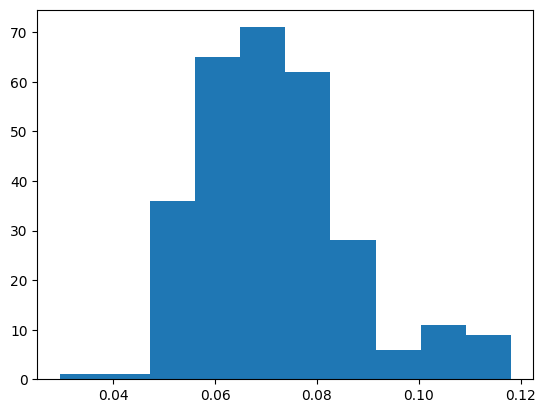

In [43]:
# Plot a histogram of vdm distances between pairs at time t=1
t=1
vdm_distances = []
for i in tqdm(range(30)):
    for j in tqdm(range(10)):
        if i != j:
            vdm_distances.append(vdm.vdm_distance(i,j,t))
vdm_distances = np.array(vdm_distances)
plt.hist(vdm_distances)
plt.show()